In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

## Loading and Preparing Data

In this section, we load the training and testing datasets and prepare the features and labels for model training and evaluation.

In [2]:
# Load the training and testing datasets
data_train = pd.read_csv('data_clean/data_train.csv')
data_test = pd.read_csv('data_clean/data_test.csv')

# Split the training data into features (X) and labels (y)
X_train, y_train = data_train.drop('label', axis=1), data_train['label']
# Split the testing data into features (X) and labels (y)
X_test, y_test = data_test.drop('label', axis=1), data_test['label']

## Inspecting Features

Next, we inspect the columns of the training dataset to see the features available for our models.

In [3]:
X_train.columns

Index(['file', 'Kincaid', 'ARI', 'Coleman-Liau', 'FleschReadingEase',
       'GunningFogIndex', 'LIX', 'SMOGIndex', 'RIX', 'DaleChallIndex',
       'total_words', 'total_sentences', 'total_characters', 'passive_voice',
       'active_voice', 'passive_toks', 'active_toks', 'verbs', 'nouns',
       'adjectives', 'adverbs', 'prepositions', 'auxiliaries',
       'coord_conjunctions', 'determiners', 'interjections', 'numbers',
       'particles', 'pronouns', 'proper_nouns', 'punctuations',
       'subordinating_conjunctions', 'symbols', 'other', 'money', 'persons',
       'norp', 'facilities', 'organizations', 'gpe', 'products', 'works',
       'dates', 'times', 'quantities', 'ordinals', 'cardinals', 'percentages',
       'stopwords', 'locations', 'laws', 'characters_per_word',
       'syll_per_word', 'words_per_sentence', 'sentences_per_paragraph',
       'type_token_ratio', 'syllables', 'wordtypes', 'long_words',
       'complex_words', 'complex_words_dc', 'tobeverb', 'auxverb',
       'c

## EMD Model Explanation

The EMD (Earth Mover's Distance) model is used to measure the distance between two probability distributions over a region. In the context of our classification task, we calculate the Wasserstein distance, a specific type of EMD, for each feature between the two classes in the training data. This distance quantifies the difference in distributions of the feature values for the two classes. Features with higher distances are considered more significant for distinguishing between the classes. By applying weights derived from these distances, we can enhance the model's ability to classify text as plain or not plain language.

In [4]:
# Initialize a dictionary to store Wasserstein distances for each feature
emd_distances = {}

# Calculate the Wasserstein distance for each feature between the two classes
for col in X_train.columns[1:]:
    emd_distances[col] = stats.wasserstein_distance(data_train[data_train['label'] == 0][col], data_train[data_train['label'] == 1][col])

# Sort the features based on the calculated distances in descending order
emd_distances = dict(sorted(emd_distances.items(), key=lambda item: item[1], reverse=True))

# Create a DataFrame from the sorted distances
emd_df = pd.DataFrame.from_dict(emd_distances, orient='index', columns=['distance'])

# Get the top features based on the distances, in this case, we selected all features.
top_features = list(emd_distances.keys())

# Create a dictionary of features with their corresponding distances
features_dict = {feature: emd_distances[feature] for feature in top_features}

# Calculate the sum of all distances
sum_emd = sum(features_dict.values())

# Calculate the weight for each feature based on its distance
weights = {feature: features_dict[feature]/sum_emd for feature in features_dict}
weights = dict(sorted(weights.items(), key=lambda item: item[1], reverse=True))

## Applying Feature Weights and Making Predictions

We apply the calculated weights to the test data features and make predictions based on the weighted distances.

In [5]:
# Create DataFrames to store the top features for the test and training sets
X_test_top = X_train[top_features].copy()
X_train_top_abs = X_train[top_features].copy()
X_train_top_pls = X_train[top_features].copy()
X_test_top_abs = X_test[top_features].copy()
X_test_top_pls = X_test[top_features].copy()

# Apply weights to the test features based on the mean distance from each class
for col in top_features:
    X_test_top_abs.loc[:, col] = abs(X_test_top_abs[col] - data_train[data_train['label'] == 0][col].mean()) * weights[col]
    X_test_top_pls.loc[:, col] = abs(X_test_top_pls[col] - data_train[data_train['label'] == 1][col].mean()) * weights[col]

# Make predictions based on the weighted distances
y_pred = []
for i in range(len(X_test_top_abs)):
    if sum(X_test_top_abs.iloc[i]) < sum(X_test_top_pls.iloc[i]):
        y_pred.append(0)
    else:
        y_pred.append(1)

## EMD Model Evaluation

Here, we evaluate the performance of our model by calculating the accuracy and F1 score based on the predicted and actual labels.

Accuracy: 0.9234534560
Recall: 0.9464990138
Precision: 0.8476484875
F1: 0.8943506115


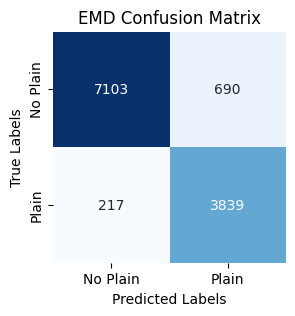

In [6]:
# Convert the predicted and actual labels to numpy arrays
y_pred = np.array(y_pred)
y_test = np.array(y_test)

# Calculate the confusion matrix
cm_emd = confusion_matrix(y_test, y_pred)

# Calculate the accuracy
accuracy = np.mean(y_pred == y_test)

# Calculate precision, recall, and F1 score
TP = np.sum(y_pred * y_test)
FP = np.sum(y_pred * (1 - y_test))
FN = np.sum((1 - y_pred) * y_test)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
F1 = 2 * precision * recall / (precision + recall)

# Print the evaluation metrics
print(f'Accuracy: {accuracy:.10f}')
print(f'Recall: {recall:.10f}')
print(f'Precision: {precision:.10f}')
print(f'F1: {F1:.10f}')

# Plot the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm_emd, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Plain', 'Plain'], yticklabels=['No Plain', 'Plain'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('EMD Confusion Matrix')
plt.show()

## Gradient Boosting Model

We train a Gradient Boosting Classifier using the top features identified through the EMD analysis. The model parameters are set to optimize performance.

In [7]:
# Initialize the Gradient Boosting Classifier with specified parameters
gbc = GradientBoostingClassifier(n_estimators=50, learning_rate=0.25, max_features=5, max_depth=8, random_state=0)

# Train the Gradient Boosting Classifier on the training data using the top features
gbc.fit(X_train[top_features], y_train)

GradientBoostingClassifier(learning_rate=0.25, max_depth=8, max_features=5,
                           n_estimators=50, random_state=0)

## GB Model Evaluation

We evaluate the performance of the Gradient Boosting Classifier by predicting the labels on the test data and calculating the accuracy, recall, precision, and F1 score.

Accuracy:  0.9835429150139252
Recall:  0.979043392504931
Precision:  0.9730458221024259
F1:  0.9760353938798083


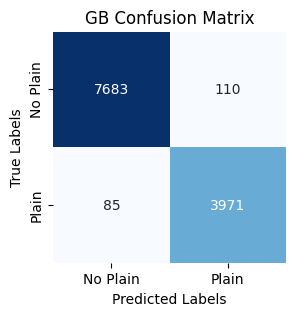

In [8]:
# Predict the labels on the test data using the trained Gradient Boosting Classifier
y_pred = gbc.predict(X_test[top_features])

# Calculate the confusion matrix
cm_gb = confusion_matrix(y_test, y_pred)

# Print the evaluation metrics
print('Accuracy: ', accuracy_score(y_test, y_pred))
print('Recall: ', recall_score(y_test, y_pred))
print('Precision: ', precision_score(y_test, y_pred))
print('F1: ', f1_score(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Plain', 'Plain'], yticklabels=['No Plain', 'Plain'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('GB Confusion Matrix')
plt.show()

## Random Forest Model

We train a Random Forest Classifier using the top features identified through the EMD analysis. The model parameters are set to optimize performance.

In [9]:
# Initialize the Random Forest Classifier with specified parameters
rfc = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=0)

# Train the Random Forest Classifier on the training data using the top features
rfc.fit(X_train[top_features], y_train)

RandomForestClassifier(max_depth=10, random_state=0)

## RF Model Evaluation

We evaluate the performance of the Random Forest Classifier by generating the confusion matrix and calculating the accuracy, recall, precision, and F1 score.

Random Forest Accuracy:  0.9773820575575998
Random Forest Recall:  0.9669625246548323
Random Forest Precision:  0.9669625246548323
Random Forest F1:  0.9669625246548323


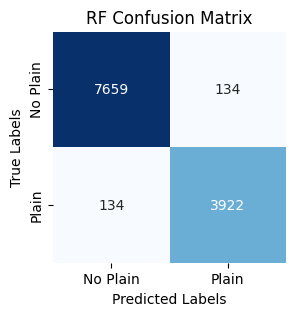

In [10]:
# Predict the labels on the test data using the trained Random Forest Classifier
y_pred_rf = rfc.predict(X_test[top_features])

# Calculate the confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

# Print the evaluation metrics
print('Random Forest Accuracy: ', accuracy_score(y_test, y_pred_rf))
print('Random Forest Recall: ', recall_score(y_test, y_pred_rf))
print('Random Forest Precision: ', precision_score(y_test, y_pred_rf))
print('Random Forest F1: ', f1_score(y_test, y_pred_rf))

# Plot the confusion matrix
plt.figure(figsize=(3, 3))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No Plain', 'Plain'], yticklabels=['No Plain', 'Plain'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('RF Confusion Matrix')
plt.show()

## Identifying Key Features

Using the trained Random Forest Classifier, we identify the most important features. Only features with an importance score above the set threshold are selected for possible further analysis.

In [11]:
# Initialize SelectFromModel with the trained Random Forest Classifier and a threshold
sfm = SelectFromModel(rfc, threshold=0.01)

# Fit SelectFromModel on the training data using the top features
sfm.fit(X_train[top_features], y_train)

# Get the selected features based on the importance threshold
selected_features = X_train[top_features].columns[sfm.get_support()]

# Print the selected features
print('Selected Features:', selected_features)

Selected Features: Index(['complex_words_dc', 'stopwords', 'proper_nouns', 'punctuations',
       'numbers', 'organizations', 'sentences_per_paragraph', 'DaleChallIndex',
       'auxiliaries', 'active_toks', 'percentages', 'active_voice',
       'subordinating_conjunctions', 'auxverb', 'norp'],
      dtype='object')
